# EDA: Client task

### Setting the enviromment: 

In [56]:
#1# Useful: 
import pandas as pd  #panda library
import numpy as np   #numpy library
import missingno as msno # data cleaning
import psycopg2    
from sqlalchemy import create_engine  
import os
from dotenv import load_dotenv     
import warnings

warnings.filterwarnings("ignore")

#2# Data visualization: 
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import json
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Collecting the data frame: 

In [57]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)
cur = conn.cursor()
query_string = "SELECT ks.price , kd.zipcode, kd.condition, ks.house_id, kd.sqft_living, kd.sqft_lot15,kd.lat, kd.long, kd.waterfront,kd.grade     FROM eda.king_county_house_details kd FULL JOIN eda.king_county_house_sales ks ON ks.house_id  = kd.id "
df_nicole_original = pd.read_sql(query_string, conn)
df_nicole_original.to_csv('data/client.csv',index=False)
conn.close()

df_nicole_original = pd.read_csv('data/client.csv')

### Preparing the data:

- Creating a copy of the original data:

In [58]:
df_nicole = df_nicole_original.copy()

- Cleaning process:

In [59]:
##Checking for duplicates: 
df_nicole.duplicated().value_counts() 

False    21594
True         3
Name: count, dtype: int64

In [60]:
df_nicole.drop_duplicates(inplace=True)
df_nicole.duplicated().value_counts() 

# df_nicole.fillna(0, inplace=True)  ##--> making sure I won't have a NaN

# #df_nicole.columns  ##-->checking the column names for the next questions


False    21594
Name: count, dtype: int64

- Checking for Null values:

In [61]:
df_nicole.isnull().sum()

price             0
zipcode           0
condition         0
house_id          0
sqft_living       0
sqft_lot15        0
lat               0
long              0
waterfront     2390
grade             0
dtype: int64

In [62]:
#In this case it makes sense to substitute the NaN values with "0" because it's indicating if a house has 
# waterfront or not (it's a categorical feature).
df_nicole.fillna(0, inplace=True)
df_nicole.isnull().sum()

price          0
zipcode        0
condition      0
house_id       0
sqft_living    0
sqft_lot15     0
lat            0
long           0
waterfront     0
grade          0
dtype: int64

- Changing the data type for better visualization:

In [63]:
df_nicole = df_nicole.astype({"waterfront": "int64"})

## Finding a center district in the map

In [64]:
houses_per_zipcode = df_nicole.groupby(["zipcode"])["house_id"].count().reset_index()

area_per_zipcode = df_nicole.groupby(["zipcode"])["lat"].mean().reset_index()  ### --> getting the latitude
long_per_zipcode = df_nicole.groupby(["zipcode"])["long"].mean().reset_index() ### --> getting the longitude
price_per_code = df_nicole.groupby(["zipcode"])["price"].mean().reset_index() ### --> getting the longitude

extract_long = long_per_zipcode["long"]
area_per_zipcode = area_per_zipcode.join(extract_long)   ###--> join longitude with latitude data

extract_houses = houses_per_zipcode["house_id"]
area_per_zipcode = area_per_zipcode.join(extract_houses) ##--> join the number of houses per zipcode in the data

extract_price = price_per_code["price"]
area_per_zipcode = area_per_zipcode.join(extract_price)

area_per_zipcode.describe()  ## ---> finding the median and the max values of houses to sell in under one zip code.

central_area = area_per_zipcode.query("house_id >= 282 and house_id <= 602") 

## filter the data set in order to be able to check which exact zip codes fits in the description we use to understand
## what could be seen has a central area ( zip code with a high number of houses to sell).

central_area.describe()

,zipcode,lat,long,house_id,price
count,36.000,36.000,36.000,36.000,36.000
mean,98075.611,47.572,-122.211,416.139,568848.546
std,50.544,0.126,0.135,101.899,234821.186
min,98001.000,47.302,-122.398,282.000,281194.870
25%,98033.750,47.519,-122.314,327.750,410267.418
50%,98062.000,47.580,-122.216,407.500,553232.295
75%,98117.250,47.680,-122.118,497.500,645340.226
max,98199.000,47.755,-121.862,602.000,1356523.991


#### Checking in the map the areas with the biggest amount of houses to sell

In [65]:
f = open('./data/KCW.geojson', encoding='utf-8')
KCW = json.load(f)
background = alt.Chart(alt.Data(values=KCW)).mark_geoshape(
        fill='white',
        stroke='black',
        #color='ColorS:Q'
        ).project('albersUsa'
        ).properties(
            width=500,
            height=300)
point = alt.Chart(area_per_zipcode).mark_point(
    opacity=1, color='red'
    ).encode(
    latitude='lat',
    longitude='long',
    color=alt.Color('house_id', scale = alt.Scale(scheme= 'turbo')),#color='sqft_lots',
    #color=alt.value('red'),
    opacity=alt.value(1)
    )   

background + point

alt.LayerChart(...)

### Specifying which areas we can see in the map: 

- Naming the areas with more big dots in it
- Finding the max, median, minimum and average price for each area

Now we gonna filter to check which zip code has the maximum amount of houses to sell, and we going to start working on our data based on this zip code.

In [66]:
most_houses_to_sell = central_area.query("house_id >= 602")
most_houses_to_sell  ## --> checking the zip code


,zipcode,lat,long,house_id,price
42,98103,47.676,-122.344,602,585048.779


Searching for this zip code online, we've found that it belongs to the district of Green Lake that also involves other zip codes. We gonna now check the prices of this area based on the information we've found online.   

## Price check for Green Lake:

In [67]:
## Collecting the data only for the Green Lake area:

houses_in_greenlake = df_nicole.query("zipcode == 98103 or zipcode == 98115")
greenlake_prices = houses_in_greenlake.describe()


mean_price = greenlake_prices["price"].iloc[1]
median_price = greenlake_prices["price"].iloc[5]
min_price = greenlake_prices["price"].iloc[3]
max_price = greenlake_prices["price"].iloc[7]

print("Average Price to buy a house in Green Lake:", mean_price)
print("Median Price of a house in Green Lake:", median_price)
print("Minimum Price to buy a house in Green Lake:", min_price)
print("Maximum Price to buy a house in Green Lake:", max_price)

Average Price to buy a house in Green Lake: 602216.712236287
Median Price of a house in Green Lake: 560000.0
Minimum Price to buy a house in Green Lake: 200000.0
Maximum Price to buy a house in Green Lake: 2300000.0


Based on Green Lake. We now go back to our map, check the areas with more red points in it and compare with the zip code map. 

[Zip Code Map for comparing](https://www.unitedstateszipcodes.org/98103/)

From our map and the Green Lake area,we going to find the surrounding areas  for price  check and comparison to our client. 



## Price check for Shoreline:

In [68]:
houses_in_shoreline = df_nicole.query("zipcode == 98133 or zipcode == 98155 or zipcode == 98177")
shoreline_prices = houses_in_shoreline.describe()

mean_price = shoreline_prices["price"].iloc[1]
median_price = shoreline_prices["price"].iloc[5]
min_price = shoreline_prices["price"].iloc[3]
max_price = shoreline_prices["price"].iloc[7]

print("Average Price to buy a house in Shoreline:", mean_price)
print("Median Price of a house in Shoreline:", median_price)
print("Minimum Price to buy a house in Shoreline:", min_price)
print("Maximum Price to buy a house in Shoreline:", max_price)

Average Price to buy a house in Shoreline: 462537.9556113903
Median Price of a house in Shoreline: 400000.0
Minimum Price to buy a house in Shoreline: 130000.0
Maximum Price to buy a house in Shoreline: 4500000.0


## Price check for Kirkland:

In [69]:
houses_in_kirkland = df_nicole.query("zipcode == 98033 or zipcode == 98034 or zipcode == 98083")
kirkland_prices = houses_in_kirkland.describe()

mean_price = kirkland_prices["price"].iloc[1]
median_price = kirkland_prices["price"].iloc[5]
min_price = kirkland_prices["price"].iloc[3]
max_price = kirkland_prices["price"].iloc[7]

print("Average Price to buy a house in Kirkland:", mean_price)
print("Median Price of a house in Kirkland:", median_price)
print("Minimum Price to buy a house in Kirkland:", min_price)
print("Maximum Price to buy a house in Kirkland:", max_price)

Average Price to buy a house in Kirkland: 646542.8270214944
Median Price of a house in Kirkland: 510000.0
Minimum Price to buy a house in Kirkland: 90000.0
Maximum Price to buy a house in Kirkland: 5110000.0


#### Comparing some features that can affect the house's price and show us some extra info of each area:

<Axes: xlabel='waterfront', ylabel='price'>

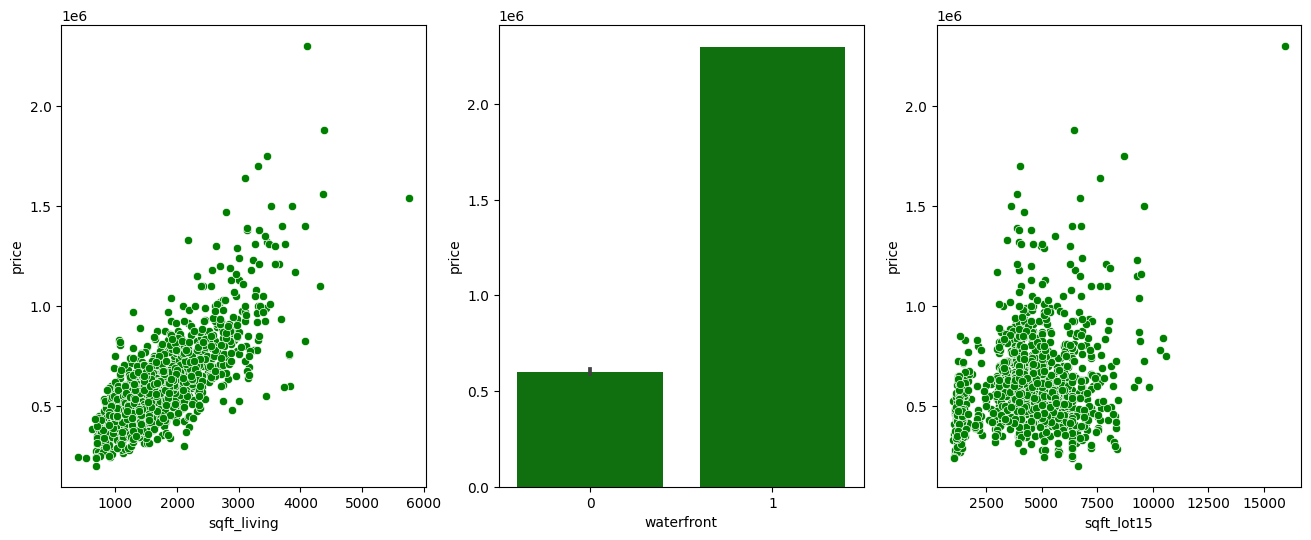

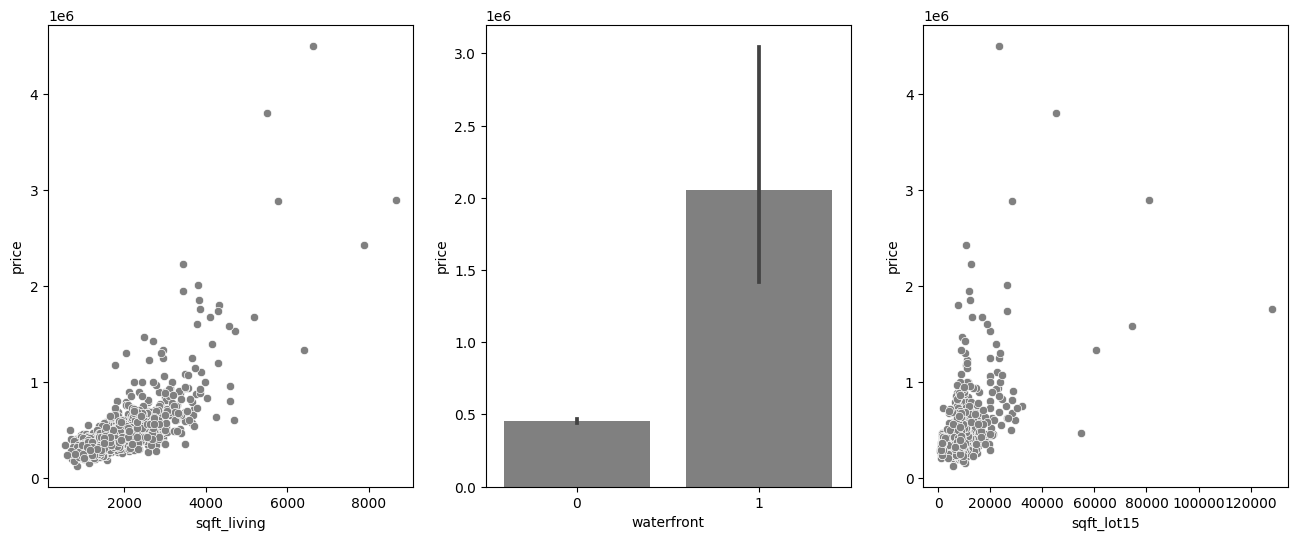

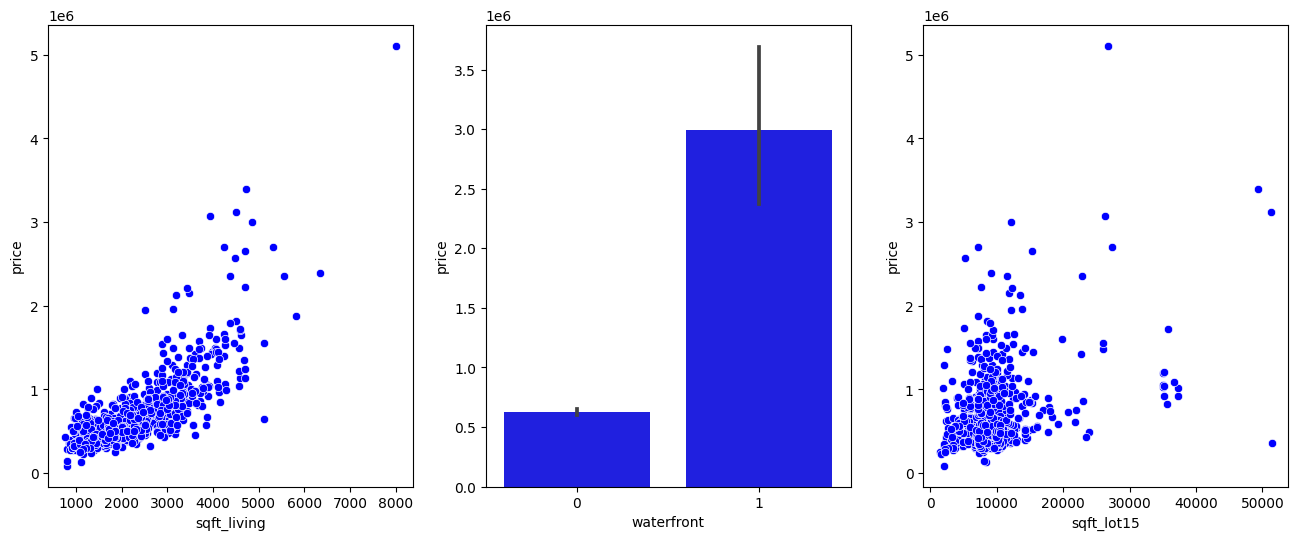

In [70]:
## Comparing some features that can affect the house's price in Green Lake area: 

fig_01 , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax
sns.scatterplot(data=houses_in_greenlake, x="sqft_living", y="price", color='green', ax= ax1)
sns.scatterplot(data=houses_in_greenlake, x="sqft_lot15", y="price", color='green', ax= ax3)
sns.barplot(data=houses_in_greenlake, x="waterfront", y="price", color='green', ax= ax2)
fig_01.savefig("visualisations/Basel_Temp_MA_Smoothing.png",dpi=300)

## Some features that can affect the house's price in Shoreline area: 

fig_02 , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2, ax3= ax
sns.scatterplot(data=houses_in_shoreline, x="sqft_living", y="price", color='gray', ax= ax1)
sns.scatterplot(data=houses_in_shoreline, x="sqft_lot15", y="price", color='gray', ax= ax3)
sns.barplot(data=houses_in_shoreline, x="waterfront", y="price", color='gray', ax= ax2)

## Some features that can affect the house's price in Kirkland area: 

fig_03 , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax
sns.scatterplot(data=houses_in_kirkland, x="sqft_living", y="price", color='blue', ax= ax1)
sns.scatterplot(data=houses_in_kirkland, x="sqft_lot15", y="price", color='blue', ax= ax3)
sns.barplot(data=houses_in_kirkland, x="waterfront", y="price", color='blue', ax= ax2)

- The comparing can also show how populated the area is as well as more or less how noble certain parts of the district can be. As we see there's multiple points in the graphic that indicates a high number of houses being sold in the area,which might imply that this area as a higher population density than the others. 

- Considering this, we could say that Green Lake it's a more lively, centralized area, followed by Kirkland  and Shoreline tends to have a bit more isolated areas. This could be affecting the prices between those areas, when you compare the average prices between them you can see that the bigger centers are more expensive to live. Also for this you can consider that Green Lake has mostly smaller properties to sell, but with the highest prices. Kirkland followed by Shoreline has bigger houses in general but cheaper than Green Lake in general. 

- The size of the closest property from each house for sell can also indicate the population density level in a certain area. Being another indicator of a downtown area or maybe a less privilege area, when compared with the prices of the houses. Green Lake, as said, has smaller but more expensive properties. Kirkland has a bit larger but also pricy properties and Shoreline has smaller but cheaper houses. Which could indicate a less privilege or more "country size" area, the second part mainly considering that the closest house has a bigger lot (which it can means there are a bit more far from each other, having less people living close to each other).  

- Our customer wants a lively and central area, which according to what we've seen could be between Green Lake and Kirkland. Both are respective central areas with higher population levels. But she also wants houses to be more middle price, which would indicate that she should first visit the properties in Kirkland. 

- However let's share options in all areas considering the average price for each one separately but ordering by interest. Kirkland (median prices for a more central area), Green Lake (high prices but most lively and central area) and Shoreline (cheaper properties but more "country side").

### Visit suggestions per middle price and good conditions: 

##### Addresses in Kirkland:

In [71]:
houses_in_kirkland.query("price == 510000.0 and condition > 3")

,price,zipcode,condition,house_id,sqft_living,sqft_lot15,lat,long,waterfront,grade
2908,510000.000,98034,4,8677900123,1600.000,14850.000,47.720,-122.249,0,7
11558,510000.000,98033,4,3888100117,1550.000,9750.000,47.681,-122.169,0,7
15547,510000.000,98033,4,3755500080,1320.000,14250.000,47.702,-122.199,0,7


##### Addresses in Green Lake:

In [72]:
houses_in_greenlake.query("price == 560000.0 and condition > 3")

,price,zipcode,condition,house_id,sqft_living,sqft_lot15,lat,long,waterfront,grade
6994,560000.000,98103,4,4083306720,1790.000,3420.000,47.649,-122.337,0,7
19066,560000.000,98103,4,1825049013,1380.000,3956.000,47.658,-122.344,0,7


##### Addresses in Shoreline: 

In [73]:
houses_in_shoreline.query("price == 400000.0 and condition > 3")

,price,zipcode,condition,house_id,sqft_living,sqft_lot15,lat,long,waterfront,grade
193,400000.000,98133,4,3663500060,2180.000,7818.000,47.761,-122.336,0,7
3356,400000.000,98133,4,9158800090,2230.000,7752.000,47.765,-122.330,0,7
9623,400000.000,98133,4,3034200530,1430.000,8822.000,47.718,-122.338,0,7
12218,400000.000,98155,5,6163901382,1630.000,8515.000,47.755,-122.317,0,7
15567,400000.000,98155,4,3971701990,1810.000,10000.000,47.768,-122.311,0,7
16372,400000.000,98133,4,9561100080,2420.000,7693.000,47.758,-122.343,0,7
